# Import Libraries & Dataset

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import category_encoders as ce

import scipy.stats as stats

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from custom_pipeline_utils import FeatureEngineer, DropColumns  # the custom transformer

RANDOM_STATE = 21
DATA_PATH = '../data/cleaned_outliers_data_saudi_used_cars.csv'  # Use the cleaned dataset (without manual feature engineering)

# Data Splitting

In [2]:
df = pd.read_csv(DATA_PATH)
TARGET = "Price"

X = df.drop(columns=TARGET)
y = df[TARGET]

# Split into train/test (holdout 20% for final test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (3052, 10), Test shape: (764, 10)


In [3]:
X_train.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable
2827,Outlander,Qassim,Mitsubishi,Automatic,Saudi,Semi Full,2020,2.4,43000,False
3487,Accent,Riyadh,Hyundai,Automatic,Saudi,Standard,2018,1.4,124975,False
1275,Sierra,Khobar,GMC,Automatic,Saudi,Full,2021,8.0,2800,False
1518,E,Dammam,Mercedes,Automatic,Gulf Arabic,Full,2017,2.0,98000,False
2193,Sportage,Riyadh,Kia,Automatic,Saudi,Standard,2019,1.6,69358,False


In [4]:
DROP_COLS = ["Negotiable", "Year"]

# Feature Engineering & Preprocessing Pipeline

In [5]:
feature_engineering_transformer = FeatureEngineer(current_year=2022)
drop_columns_transformer = DropColumns(columns=DROP_COLS)
df_fe = feature_engineering_transformer.transform(X_train)
df_fe = drop_columns_transformer.transform(df_fe)

cat_cols = (
    df_fe.select_dtypes(include=['object','bool','category'])
    .columns.tolist()
)
num_cols = (
    df_fe.select_dtypes(include=['int64','float64'])
    .drop(columns=[TARGET], errors='ignore')
    .columns.tolist()
)

In [6]:
print(f"Categorical columns: {cat_cols}")
print(f"Numerical columns: {num_cols}")

Categorical columns: ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options', 'IsVintage', 'IsBigEngine']
Numerical columns: ['Engine_Size', 'Mileage', 'Car_Age']


**Feature Engineering**

* **Car Age**
  `Car_Age` is created as a more direct and monotonic predictor of price, since vehicle value typically decreases with age rather than with production year.

* **Vintage Flag**
  `IsVintage` flags vehicles 30+ years old. These cars behave differently in the market, so they are marked to help the model treat them separately.

* **Big Engine Flag**
  `IsBigEngine` marks cars with engine sizes above 7.0L. This feature highlights rare, high-performance or luxury vehicles that do not follow standard pricing trends.

* **Dropping Unnecessary Columns**
  Features used only for outlier detection, redundancy, or already handled elsewhere (like `Negotiable` and `Year`) are dropped to keep the dataset focused for modeling.

In [7]:
# Cardinality splitting for encoding choices
LOW_CARD_THRESH = 10
low_card_cat  = [c for c in cat_cols if df_fe[c].nunique() <= LOW_CARD_THRESH]
high_card_cat = [c for c in cat_cols if df_fe[c].nunique() >  LOW_CARD_THRESH]
skewed_cols   = [c for c in num_cols if abs(df_fe[c].skew()) > 1.0]
num_plain     = [c for c in num_cols if c not in skewed_cols]

# ColumnTransformer for sklearn models
preproc = ColumnTransformer(
    transformers=[
        ("low", OneHotEncoder(drop="first", handle_unknown="ignore"), low_card_cat),
        ("bin", ce.BinaryEncoder(),                                   high_card_cat),
        ("num", RobustScaler(),                                     num_plain),
        ("log", Pipeline([
                    ("l", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
                    ("s", RobustScaler())]),                        skewed_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

In [8]:
print("\n>> low-cardinal cats:",  low_card_cat)
print(">> high-cardinal cats:", high_card_cat)
print(">> numeric cols:     ",  num_plain)
print(">> skewed cols:     ",  skewed_cols)


>> low-cardinal cats: ['Gear_Type', 'Origin', 'Options', 'IsVintage', 'IsBigEngine']
>> high-cardinal cats: ['Type', 'Region', 'Make']
>> numeric cols:      ['Engine_Size']
>> skewed cols:      ['Mileage', 'Car_Age']


In [9]:
preproc

ColumnTransformer(transformers=[('low',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['Gear_Type', 'Origin', 'Options', 'IsVintage',
                                  'IsBigEngine']),
                                ('bin', BinaryEncoder(),
                                 ['Type', 'Region', 'Make']),
                                ('num', RobustScaler(), ['Engine_Size']),
                                ('log',
                                 Pipeline(steps=[('l',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('s', RobustScaler())]),
                                 ['Mileage', 'Car_Age'])],
                  verbose_feature_names_out=False)

**Feature Preprocessing & Splitting**

* **Categorical/Numerical Splits**
  Categorical features are split by cardinality (few vs. many categories) to apply the most efficient encoding. Numeric features are divided into regular and highly skewed columns for the right scaling/transform.

* **Log Transform for Skewed Features**
  Features with high skew (like `Mileage` and `Car_Age`) are log-transformed before scaling to reduce the influence of extreme values and help models learn better.

# Benchmarking Model

**Benchmark Model Selection**

A diverse set of regression models is chosen to establish baseline performance and ensure robust comparison across different algorithm types:

* **ElasticNet:** A regularized linear regression model combining L1 and L2 penalties. It serves as a simple baseline and is robust to collinearity.
* **KNN (K-Nearest Neighbors):** A non-parametric, instance-based model that can capture local patterns and non-linearities, but may struggle with high-dimensional data.
* **Decision Tree:** A simple tree-based model that can learn non-linear relationships and is easy to interpret, but prone to overfitting.
* **Random Forest:** An ensemble of decision trees that reduces variance and improves generalization.
* **XGBoost (XGB):** A gradient-boosted tree model known for its strong predictive performance and ability to handle complex data patterns.
* **LightGBM:** Another gradient-boosted framework optimized for speed and efficiency, particularly with large datasets.
* **CatBoost:** A gradient-boosted model that natively handles categorical variables and often performs well on tabular data.

Each model is wrapped in a unified pipeline that includes feature engineering, preprocessing, and a log transformation of the target variable to better model skewed price distributions.
**5-fold cross-validation** is used to evaluate the models, with mean absolute error (MAE) as the primary metric, along with RMSE and MAPE for additional context.
The best-performing model is selected as the initial benchmark for further optimization.

In [10]:
models = {
    "ElasticNet":   ElasticNet(random_state=RANDOM_STATE),
    "KNN":          KNeighborsRegressor(),
    "DecisionTree": DecisionTreeRegressor(random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(random_state=RANDOM_STATE),
    "XGB":          XGBRegressor(random_state=RANDOM_STATE, verbosity=0),
    "LightGBM":     LGBMRegressor(random_state=RANDOM_STATE, verbose=-1),
    "CatBoost":     CatBoostRegressor(random_state=RANDOM_STATE, logging_level="Silent")
}

cv   = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

from sklearn.base import clone

best_mae   = float("inf")
best_benchmark_name  = None
best_benchmark_pipe  = None

results    = []
pipelines  = {}

# Benchmark each model, store its pipeline and its MAE
for name, base_model in models.items():
    pipe = Pipeline([
        ("fe",   FeatureEngineer(current_year=2022)),
        ("drop_unused", DropColumns(DROP_COLS)),
        ("prep", preproc),
        ("model", TransformedTargetRegressor(
                      base_model,
                      func=np.log1p, inverse_func=np.expm1))
    ])
    pipelines[name] = pipe

    # cross-val MAE (we invert because we're using neg_mean_absolute_error)
    mae_scores = -cross_val_score(pipe, X_train, y_train,
                                  cv=cv, scoring="neg_mean_absolute_error")
    mean_mae   = mae_scores.mean()

    results.append({
        "Model": name,
        "MAE":   mean_mae,
        "RMSE":  -cross_val_score(pipe, X_train, y_train, cv=cv,
                                  scoring="neg_root_mean_squared_error").mean(),
        "MAPE":  -cross_val_score(pipe, X_train, y_train, cv=cv,
                                  scoring="neg_mean_absolute_percentage_error").mean(),
    })

    # If this is the best so far, remember it
    if mean_mae < best_mae:
        best_mae  = mean_mae
        best_benchmark_name = name
        # clone so we get an unfitted pipeline we can later fit on all data
        best_benchmark_pipe = clone(pipe)

# Assemble and display benchmark table
benchmark_df = pd.DataFrame(results).sort_values("MAE").reset_index(drop=True)
display(benchmark_df)

print(f"Best benchmark model: {best_benchmark_name} (MAE={best_mae:.4f})")

d:\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
d:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid fe

,Model,MAE,RMSE,MAPE
0,CatBoost,17630.999996,35134.460319,0.690629
1,LightGBM,18843.172359,36625.772118,0.698877
2,RandomForest,19393.047902,39417.046198,0.740957
3,XGB,19520.041406,38602.640234,0.711822
4,KNN,21502.276329,40577.801472,0.854965
5,DecisionTree,26720.427504,56647.199875,1.053925
6,ElasticNet,44351.814054,76778.278069,1.219442


Best benchmark model: CatBoost (MAE=17631.0000)


**CatBoost was selected as the best benchmark model** because it achieved the lowest Mean Absolute Error (MAE) among all tested algorithms. CatBoost is particularly well-suited for tabular data with categorical features, as it handles categorical variables natively and captures complex non-linear relationships. Its strong performance in both MAE and other metrics makes it the optimal starting point for further model tuning and business impact analysis.

In [11]:
# Fit the best pipeline on all the training data
catboost_benchmark_model = best_benchmark_pipe.fit(X_train, y_train)

In [12]:
def evaluate_regression_model(
    model, X_test, y_test,
    bins = [0, 10000, 35000, 60000, 95000, 180000, np.inf],
    labels = ["0–10k", "10k–35k", "35k–60k", "60k–95k", "95k–180k", "180k+"],
    show_plot=True
):
    y_pred = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_pred)
    
    print("\n─────────  Hold-out test  ─────────")
    print(f"MAE test : {mae_test:,.2f}")
    print(f"MAPE test: {mape_test:.3f}")

    # Price band analysis
    df_eval = pd.DataFrame({"y_true": y_test, "y_pred": y_pred}).reset_index(drop=True)
    df_eval["price_band"] = pd.cut(df_eval["y_true"], bins=bins, labels=labels)

    def mape(y_true, y_pred):
        # Avoid division by zero
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        nonzero = y_true != 0
        return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero]))

    band_stats = (
        df_eval
        .groupby("price_band")
        .apply(lambda g: pd.Series({
            "count": len(g),
            "MAE": np.mean(np.abs(g.y_true - g.y_pred)),
            "MAPE": mape(g.y_true, g.y_pred)
        }))
    )

    print("\nPer-Price Band Statistics:")
    print(band_stats)
    
    if show_plot:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        band_stats["MAE"].plot(kind="bar", ax=ax[0], title="MAE per Price Band")
        ax[0].set_ylabel("MAE (SAR)")
        ax[0].set_xlabel("Price Band")
        band_stats["MAPE"].plot(kind="bar", ax=ax[1], title="MAPE per Price Band")
        ax[1].set_ylabel("MAPE")
        ax[1].set_xlabel("Price Band")
        plt.tight_layout()
        plt.show()
    
    return {
        "mae_test": mae_test,
        "mape_test": mape_test,
        "band_stats": band_stats,
        "y_pred": y_pred
    }
    
def residual_analysis(
    y_true,
    y_pred,
    X_test=None,
    feature_cols=['Make', 'Type', 'Year', 'Engine_Size', 'Mileage', 'Options', 'Origin'],
    n_outliers=5
):
    """
    Plots residual diagnostics and displays outlier cases.
    
    Parameters:
        y_true (array-like): True target values
        y_pred (array-like): Predicted target values
        X_test (DataFrame, optional): Features for error analysis
        feature_cols (list): Feature columns to display in outlier analysis
        n_outliers (int): Number of worst outliers to display (top/bottom)
    """
    df_resid = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "residual": np.array(y_true) - np.array(y_pred)
    }).reset_index(drop=True)
    
    # Residual plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(df_resid["residual"], bins=40)
    axes[0].set_title("Histogram of residuals")
    stats.probplot(df_resid["residual"], dist="norm", plot=axes[1])
    axes[1].set_title("QQ-plot of residuals")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 4))
    plt.scatter(df_resid["y_pred"], df_resid["residual"], alpha=0.7)
    plt.axhline(0, color="black", lw=1)
    plt.xlabel("Predicted price")
    plt.ylabel("Residual (true – pred)")
    plt.title("Residuals vs. Predicted")
    plt.tight_layout()
    plt.show()
    
    # Outlier detection (using 3*std rule)
    rstd = df_resid["residual"].std()
    outliers = df_resid[np.abs(df_resid["residual"]) > 3*rstd]
    print(f"Top {n_outliers} worst negative and positive prediction errors (residuals > 3*std):")
    display(outliers.sort_values("residual").head(n_outliers))
    display(outliers.sort_values("residual", ascending=False).head(n_outliers))
    
    # Show example features for worst errors (if X_test provided)
    if X_test is not None:
        bad_idx = outliers.index
        selected_cols = [col for col in feature_cols if col in X_test.columns]
        outlier_analysis = pd.DataFrame({
            **{col: X_test.iloc[bad_idx][col].values for col in selected_cols},
            'True_Price': np.array(y_true)[bad_idx],
            'Predicted_Price': np.array(y_pred)[bad_idx],
            'Difference': np.array(y_true)[bad_idx] - np.array(y_pred)[bad_idx],
            'Error_Percent': 100 * (np.array(y_true)[bad_idx] - np.array(y_pred)[bad_idx]) / np.array(y_true)[bad_idx]
        })
        outlier_analysis['Abs_Error_Pct'] = np.abs(outlier_analysis['Error_Percent'])
        outlier_analysis = outlier_analysis.sort_values('Abs_Error_Pct', ascending=False)
        print(f"\nOutlier feature details (sorted by absolute error %):")
        display(outlier_analysis.head(n_outliers*2))

    return df_resid, outliers

Benchmark model evalaution & residual analysis:


─────────  Hold-out test  ─────────
MAE test : 17,177.19
MAPE test: 0.947

Per-Price Band Statistics:
            count           MAE       MAPE
price_band                                
0–10k        31.0  39795.180514  18.446077
10k–35k     180.0   5722.983941   0.257896
35k–60k     206.0   7900.855386   0.165329
60k–95k     170.0  14744.552050   0.196443
95k–180k    129.0  26128.099253   0.201187
180k+        48.0  69893.991847   0.250994


C:\Users\User\AppData\Local\Temp\ipykernel_12324\579574011.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("price_band")
C:\Users\User\AppData\Local\Temp\ipykernel_12324\579574011.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


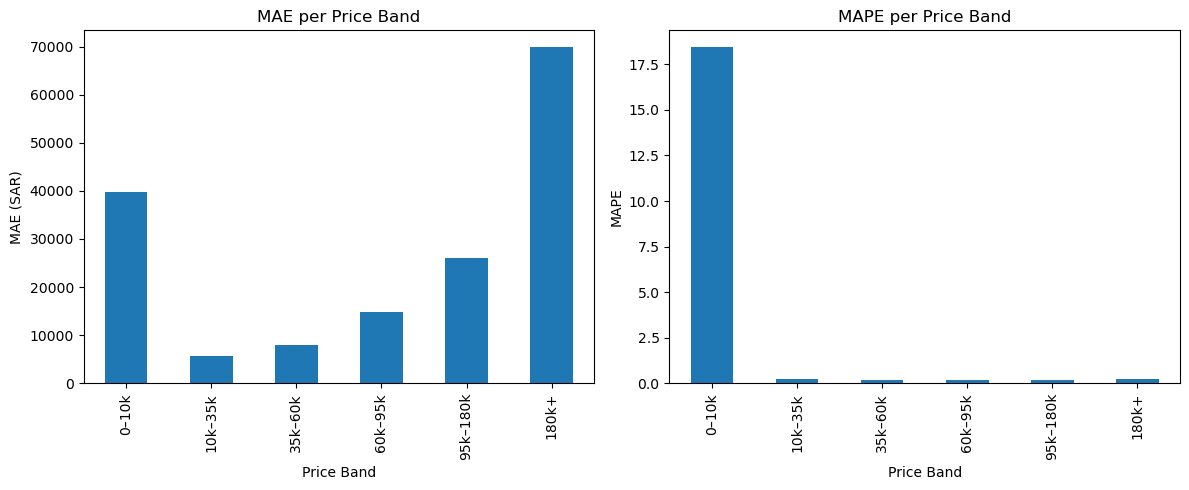

In [13]:
# ===========================================
# Best Benchmark Model Evaluation (on Test Set)
# ===========================================
result = evaluate_regression_model(catboost_benchmark_model, X_test, y_test)
y_pred = result["y_pred"]

**Hold-out Test Performance**

* **MAE (Mean Absolute Error):** 17 177 SAR
* **MAPE (Mean Absolute Percentage Error):** 94.7 %

*A MAPE of 0.947 corresponds to 94.7 %, meaning on average our absolute error is about 95 % of the true price.*

Key Takeaways

1. **Overall fit** is acceptable on mid-range cars (10–180 k SAR) with MAPE < 30 %.
2. **Extreme ends** (very cheap or very expensive) suffer huge relative errors due to data sparsity and heteroskedasticity.

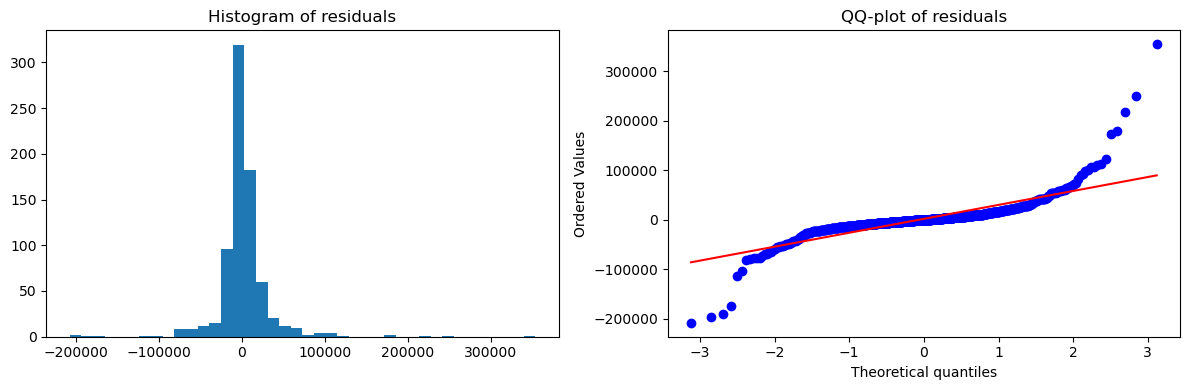

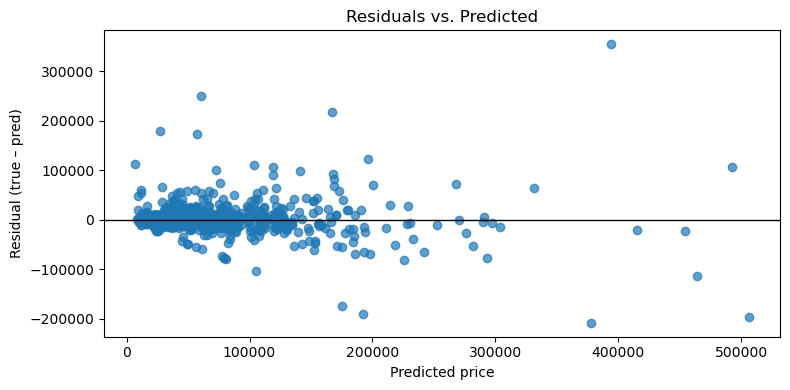

Top 5 worst negative and positive prediction errors (residuals > 3*std):


,y_true,y_pred,residual
517,170000,377738.085123,-207738.085123
136,310000,506401.457500,-196401.457500
267,2560,192351.627215,-189791.627215
332,1723,175137.916831,-173414.916831
438,350000,463656.090852,-113656.090852


,y_true,y_pred,residual
185,748000,393967.022642,354032.977358
387,310000,60380.219102,249619.780898
576,385000,166773.072748,218226.927252
561,207000,26997.737822,180002.262178
274,230000,56932.797337,173067.202663



Outlier feature details (sorted by absolute error %):


,Make,Type,Year,Engine_Size,Mileage,Options,Origin,True_Price,Predicted_Price,Difference,Error_Percent,Abs_Error_Pct
7,Toyota,Hilux,2021,2.7,37000,Full,Saudi,1723,175137.916831,-173414.916831,-10064.707883,10064.707883
4,Toyota,Land Cruiser,2020,4.0,30000,Standard,Saudi,2560,192351.627215,-189791.627215,-7413.735438,7413.735438
2,Chevrolet,Tahoe,2016,5.3,140641,Standard,Saudi,2333,105495.041566,-103162.041566,-4421.862047,4421.862047
11,Land Rover,Range Rover,2018,5.0,26000,Full,Saudi,170000,377738.085123,-207738.085123,-122.198874,122.198874
0,Hyundai,Azera,2021,3.5,11000,Standard,Saudi,120000,6774.242502,113225.757498,94.354798,94.354798
12,Ford,Expedition,2021,1.6,2500,Semi Full,Saudi,207000,26997.737822,180002.262178,86.957615,86.957615
9,Rolls-Royce,Ghost,2010,6.0,175000,Full,Saudi,310000,60380.219102,249619.780898,80.522510,80.522510
5,Lexus,ES,2021,3.5,25000,Full,Saudi,230000,56932.797337,173067.202663,75.246610,75.246610
1,Bentley,Flying Spur,2015,6.0,47000,Full,Saudi,310000,506401.457500,-196401.457500,-63.355309,63.355309
13,Maserati,Levante,2020,3.0,3000,Full,Saudi,385000,166773.072748,218226.927252,56.682319,56.682319


In [14]:
df_resid, outliers = residual_analysis(y_test, y_pred, X_test=X_test)

Residual Analysis of the Benchmark Model

1. Residual vs. Predicted Price
- **Heteroscedasticity**: The vertical spread of residuals increases with predicted price, indicating larger absolute errors on higher-priced cars.
- **Systematic bias**:
  - **Over-prediction** for very cheap cars (residuals > 0 at low ŷ).
  - **Under-prediction** for expensive cars (residuals < 0 at high ŷ).

2. Residual Distribution and Normality
- **Histogram**:  
  - Sharp peak around zero but **heavy tails** beyond ±100 000 SAR.  
  - A small number of extreme errors distort the distribution.
- **QQ-plot**:  
  - Central points closely follow the normal line.  
  - Large deviations in both tails confirm non-normality and outliers on both ends.

3. Largest Prediction Errors (|residual| > 3 × std)
- **Top negative errors** (model predicted far above true price):  
  - True=170 000 SAR -> Pred≈377 738 SAR (residual −207 738)  
  - True=2 560 SAR -> Pred≈192 352 SAR (residual −189 792)  
  - True=1 723 SAR -> Pred≈175 138 SAR (residual −173 415)  
- **Top positive errors** (model predicted far below true price):  
  - True=748 000 SAR -> Pred≈393 967 SAR (residual +354 033)  
  - True=385 000 SAR -> Pred≈166 773 SAR (residual +218 227)  

4. Feature Patterns in Outliers
- **Ultra-cheap listings** (true < 5 000 SAR) are frequently over-predicted by orders of magnitude.  
- **Luxury brands** (Rolls-Royce, Bentley, Maserati, high-end SUVs) are under-predicted by 60–80 %.  
- Indicates the model lacks sufficient representation or encoding of extreme low-price bargains and rare high-end makes.

**Key takeaway:**  
The benchmark model performs well in the mid-range but struggles at both tails. To improve:
- Enhance feature encoding for rare brands (e.g. target encoding or CatBoost native categorical handling).  
- Consider a heteroscedastic-aware objective (e.g. log-transform, Huber loss) to tame heavy tails.

Residual Distribution is Non-Normal and Heteroscedastic

* The histogram and QQ-plot of residuals show heavy tails and significant skew, rather than the desired bell-shaped (normal) distribution.
* Residuals versus predicted price plot shows that the error variance increases with price (heteroscedasticity).
* This pattern suggests that model errors are not evenly distributed and worsen for higher-priced vehicles, leading to unreliable predictions for both cheap and expensive cars.

In [16]:
def plot_model_feature_importance_from_pipeline(
    pipeline,
    X_test,
    fe_step='fe',
    drop_step='drop_unused',
    prep_step='prep',
    model_step='model',
    regressor_attr='regressor_',
    importance_type='FeatureImportance',
    figsize=(8,6),
    top_n=None,  # Optionally show only top N features
    title="CatBoost Feature Importance"
):
    """
    Extracts and plots feature importances from a fitted pipeline (with FeatureEngineering, DropColumns, ColumnTransformer, and a regressor).
    
    Parameters:
        pipeline: fitted sklearn pipeline
        X_test: raw test features
        fe_step, drop_step, prep_step: pipeline step names for FE, drop, preprocessing
        model_step: pipeline step name for final model (TransformedTargetRegressor)
        regressor_attr: attribute name for underlying regressor
        importance_type: importance type for CatBoost
        figsize: plot size
        top_n: if set, only show top N features
        title: plot title
    """
    # 1. Extract pipeline components
    fe = pipeline.named_steps[fe_step]
    drop = pipeline.named_steps[drop_step]
    prep = pipeline.named_steps[prep_step]
    model = pipeline.named_steps[model_step]
    reg = getattr(model, regressor_attr)

    # 2. Preprocess X_test through all steps (without y)
    X_test_fe = fe.transform(X_test)
    X_test_fe = drop.transform(X_test_fe)
    X_test_enc = prep.transform(X_test_fe)
    feat_names = prep.get_feature_names_out()
    X_test_pre = pd.DataFrame(X_test_enc, columns=feat_names, index=X_test.index)

    # 3. Get feature importances
    importances = reg.get_feature_importance(type=importance_type)
    fi = pd.Series(importances, index=X_test_pre.columns).sort_values()
    if top_n is not None:
        fi = fi.tail(top_n)

    # 4. Plot
    plt.figure(figsize=figsize)
    fi.plot.barh()
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return fi

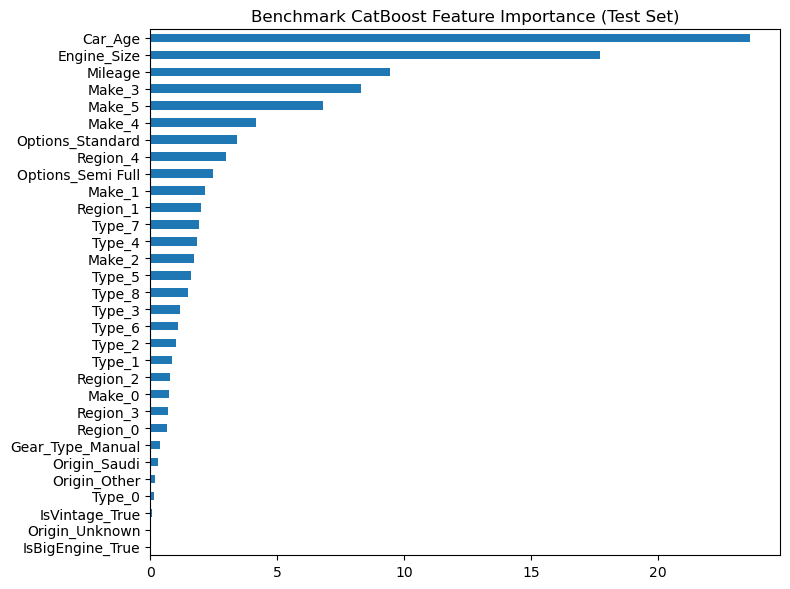

In [17]:
fi_cb = plot_model_feature_importance_from_pipeline(
    catboost_benchmark_model,
    X_test,
    title="Benchmark CatBoost Feature Importance (Test Set)"
)

Brand and Category Features are Underutilized

* Feature importance from CatBoost and permutation analysis shows that numeric features (Car Age, Engine Size, Mileage) dominate the model’s decisions.
* Categorical features such as Make and Type have much lower importance, even though certain brands (e.g., Rolls-Royce, Bentley) should strongly influence price.
* The worst predictions are dominated by rare or luxury brands, indicating that the model is not effectively learning the price impact of these categories.
* The current encoding method is insufficient for capturing the "brand premium" effect, causing the model to regress prices of rare brands toward the mean.

---

#### Next Steps (Actionable Summary)

1. Use target encoding or CatBoost’s native categorical support for brand/category features to properly capture their impact.
2. Address extreme outliers through winsorization/capping or consider training segmented models for distinct price ranges.
3. After these fixes, re-evaluate model performance and re-tune if necessary. This should result in lower and more consistent MAE and MAPE across all price segments.

# Adjusted Benchmark Model (after data fixing)

Most of the problems are related to the data conditions and how to handle them. So, I will try to fix them using the benchmark model first, before finally committing to the best approach to the data for the hyperparameter tuning, because tuning is expensive and should only be done after everything else is fixed.

Target Encoding  

- **What it does**: Replaces each category level (e.g. "Rolls-Royce") with the historical mean of the target (price) for that level, optionally shrunk toward the global mean to prevent overfitting.  
- **Benefit**: Gives a direct, numeric "brand premium" signal that any regressor can use, luxury makes carry their own average price.

Native CatBoost Categorical Handling  
- **What it does**: Takes raw categorical columns and, via ordered boosting, computes per-category statistics on the fly (without leakage), encoding levels internally at each tree split.  
- **Benefit**: Automatically learns optimal encodings and combinations for high-cardinality features, with minimal manual preprocessing.

Why Try Both  
- **Target Encoding** is model-agnostic and transparent, but needs careful smoothing to avoid leakage.  
- **CatBoost’s native support** is leakage-safe and fully integrated, yet may behave differently on rare levels.  
- **Comparing both** lets us confirm that we’ve captured the full "brand effect" and choose the encoding that best reduces tail errors and overall MAE/MAPE.  


## Target Encoding for Categorical Features

In [18]:
from category_encoders import TargetEncoder

In [19]:
target_preprocess = ColumnTransformer([
    ("low", OneHotEncoder(drop="first", handle_unknown="ignore"), low_card_cat),
        # ("bin", ce.BinaryEncoder(),                                   high_card_cat),
    ("te", TargetEncoder(cols=high_card_cat), high_card_cat),
    ("num", RobustScaler(), num_plain),
    ("log", Pipeline([
        ("ln", FunctionTransformer(np.log1p)),
        ("sc", RobustScaler())
    ]), skewed_cols),
], remainder="drop",
    verbose_feature_names_out=False
)

target_pipeline = Pipeline([
        ("fe",   FeatureEngineer(current_year=2022)),
        ("drop_unused", DropColumns(DROP_COLS)),
        ("prep", target_preprocess),
        ("model", TransformedTargetRegressor(
                      CatBoostRegressor(random_state=RANDOM_STATE, logging_level="Silent"),
                      func=np.log1p, inverse_func=np.expm1))
    ])

In [20]:
target_catboost_benchmark_model = target_pipeline.fit(X_train, y_train)
target_catboost_benchmark_model

Pipeline(steps=[('fe', FeatureEngineer()),
                ('drop_unused', DropColumns(columns=['Negotiable', 'Year'])),
                ('prep',
                 ColumnTransformer(transformers=[('low',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gear_Type', 'Origin',
                                                   'Options', 'IsVintage',
                                                   'IsBigEngine']),
                                                 ('te',
                                                  TargetEncoder(cols=['Type',
                                                                      'Region',
                                                                      'Make']),
                                                  ['Type', 'Region', 'Make']),
                                                 ('num', RobustScaler(),
                                                  ['Engine_Size']),
                                                 ('log',
                                                  Pipeline(steps=[('ln',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('sc',
                                                                   RobustScaler())]),
                                                  ['Mileage', 'Car_Age'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=<catboost.core.CatBoostRegressor object at 0x0000022813BFB200>))])


─────────  Hold-out test  ─────────
MAE test : 16,252.17
MAPE test: 0.926

Per-Price Band Statistics:
            count           MAE       MAPE
price_band                                
0–10k        31.0  40055.951505  17.886114
10k–35k     180.0   6878.231635   0.299127
35k–60k     206.0   7546.279634   0.159276
60k–95k     170.0  13729.433952   0.183947
95k–180k    129.0  25356.469049   0.194844
180k+        48.0  57860.783172   0.201521


C:\Users\User\AppData\Local\Temp\ipykernel_12324\579574011.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("price_band")
C:\Users\User\AppData\Local\Temp\ipykernel_12324\579574011.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


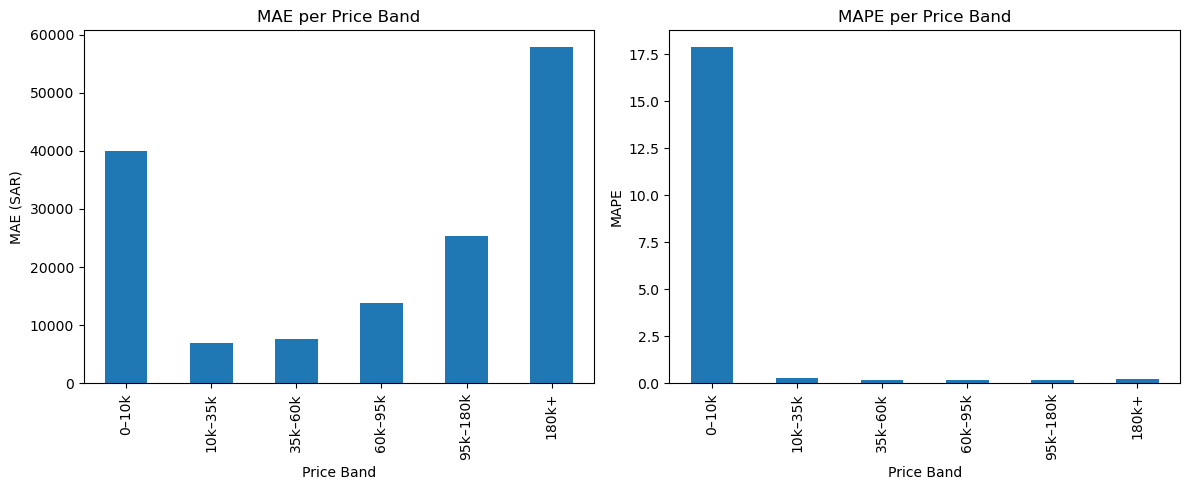

In [21]:
result = evaluate_regression_model(target_catboost_benchmark_model, X_test, y_test)
y_pred = result["y_pred"]

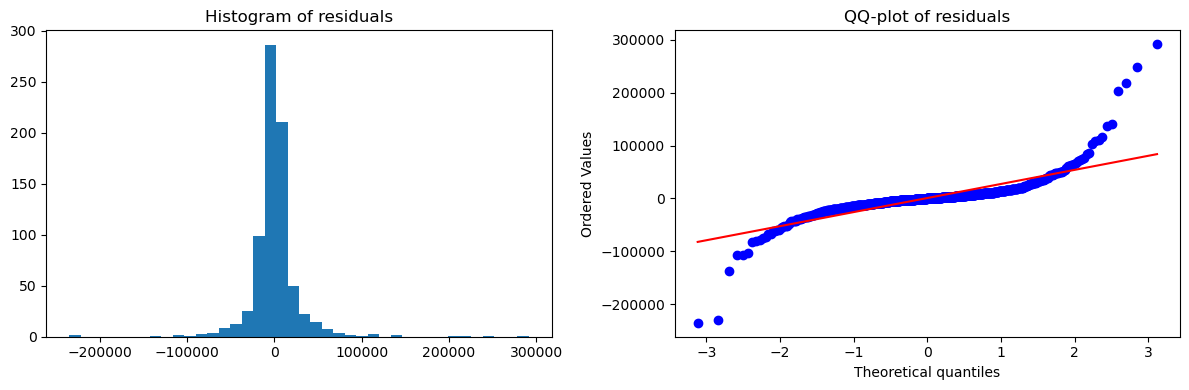

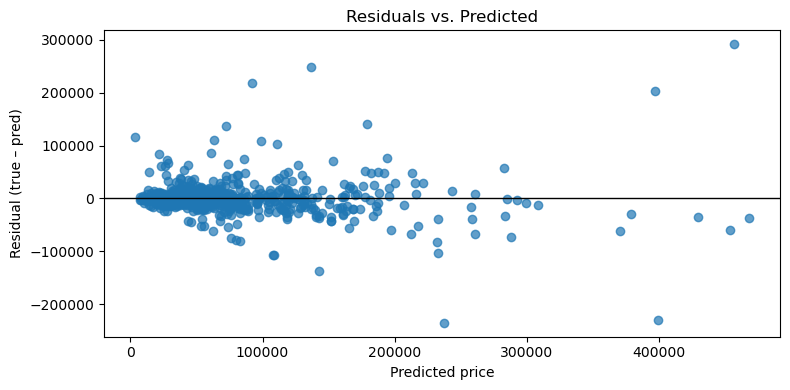

Top 5 worst negative and positive prediction errors (residuals > 3*std):


,y_true,y_pred,residual
267,2560,237116.298155,-234556.298155
517,170000,399197.319031,-229197.319031
734,5500,142622.455981,-137122.455981
332,1723,107936.113807,-106213.113807
168,2333,108508.581419,-106175.581419


,y_true,y_pred,residual
185,748000,456947.259511,291052.740489
576,385000,136696.741358,248303.258642
387,310000,91774.905176,218225.094824
307,599000,396824.666296,202175.333704
645,320000,178826.129025,141173.870975



Outlier feature details (sorted by absolute error %):


,Make,Type,Year,Engine_Size,Mileage,Options,Origin,True_Price,Predicted_Price,Difference,Error_Percent,Abs_Error_Pct
4,Toyota,Land Cruiser,2020,4.0,30000,Standard,Saudi,2560,237116.298155,-234556.298155,-9162.355397,9162.355397
6,Toyota,Hilux,2021,2.7,37000,Full,Saudi,1723,107936.113807,-106213.113807,-6164.429124,6164.429124
2,Chevrolet,Tahoe,2016,5.3,140641,Standard,Saudi,2333,108508.581419,-106175.581419,-4551.032208,4551.032208
15,Other,Other,2021,1.2,3000,Semi Full,Other,5500,142622.455981,-137122.455981,-2493.135563,2493.135563
10,Land Rover,Range Rover,2018,5.0,26000,Full,Saudi,170000,399197.319031,-229197.319031,-134.821952,134.821952
0,Hyundai,Azera,2021,3.5,11000,Standard,Saudi,120000,3448.682670,116551.317330,97.126098,97.126098
14,BMW,X,2020,2.0,22000,Semi Full,Gulf Arabic,130000,233129.746005,-103129.746005,-79.330574,79.330574
8,Rolls-Royce,Ghost,2010,6.0,175000,Full,Saudi,310000,91774.905176,218225.094824,70.395192,70.395192
9,Dodge,Durango,2019,8.0,13906,Full,Saudi,210000,72256.133880,137743.866120,65.592317,65.592317
12,Maserati,Levante,2020,3.0,3000,Full,Saudi,385000,136696.741358,248303.258642,64.494353,64.494353


In [22]:
df_resid, outliers = residual_analysis(y_test, y_pred, X_test=X_test)

## Let CatBoost Handle Categorical Features Internally

In [23]:
native_catboost_preprocess = ColumnTransformer([
    ("num", RobustScaler(), num_plain),
    ("log", Pipeline([
        ("ln", FunctionTransformer(np.log1p)),
        ("sc", RobustScaler())
    ]), skewed_cols),
], remainder="passthrough",       # everything else (i.e. cat_cols) gets passed through
    verbose_feature_names_out=False
)

# compute the positions of categorical cols after transformation
n_num = len(num_plain) + len(skewed_cols)
cat_feature_indices = list(range(n_num, n_num + len(cat_cols)))

# assemble the full pipeline
native_catboost_pipeline = Pipeline([
    ("fe",   FeatureEngineer(current_year=2022)),
    ("drop_unused", DropColumns(DROP_COLS)),
    ("pre", native_catboost_preprocess),
    ("model", TransformedTargetRegressor(
                      CatBoostRegressor(random_state=RANDOM_STATE, logging_level="Silent", cat_features=cat_feature_indices),
                      func=np.log1p, inverse_func=np.expm1))
])

In [24]:
native_catboost_pipeline_benchmark_model = native_catboost_pipeline.fit(X_train, y_train)
native_catboost_pipeline_benchmark_model

d:\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('fe', FeatureEngineer()),
                ('drop_unused', DropColumns(columns=['Negotiable', 'Year'])),
                ('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['Engine_Size']),
                                                 ('log',
                                                  Pipeline(steps=[('ln',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('sc',
                                                                   RobustScaler())]),
                                                  ['Mileage', 'Car_Age'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=<catboost.core.CatBoostRegressor object at 0x00000228123D5EB0>))])

C:\Users\User\AppData\Local\Temp\ipykernel_12324\579574011.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("price_band")
C:\Users\User\AppData\Local\Temp\ipykernel_12324\579574011.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({



─────────  Hold-out test  ─────────
MAE test : 16,648.39
MAPE test: 0.921

Per-Price Band Statistics:
            count           MAE       MAPE
price_band                                
0–10k        31.0  39085.326464  17.880470
10k–35k     180.0   5446.235643   0.239909
35k–60k     206.0   8349.880041   0.175544
60k–95k     170.0  14963.486866   0.201201
95k–180k    129.0  25792.990428   0.200191
180k+        48.0  61171.666927   0.208278


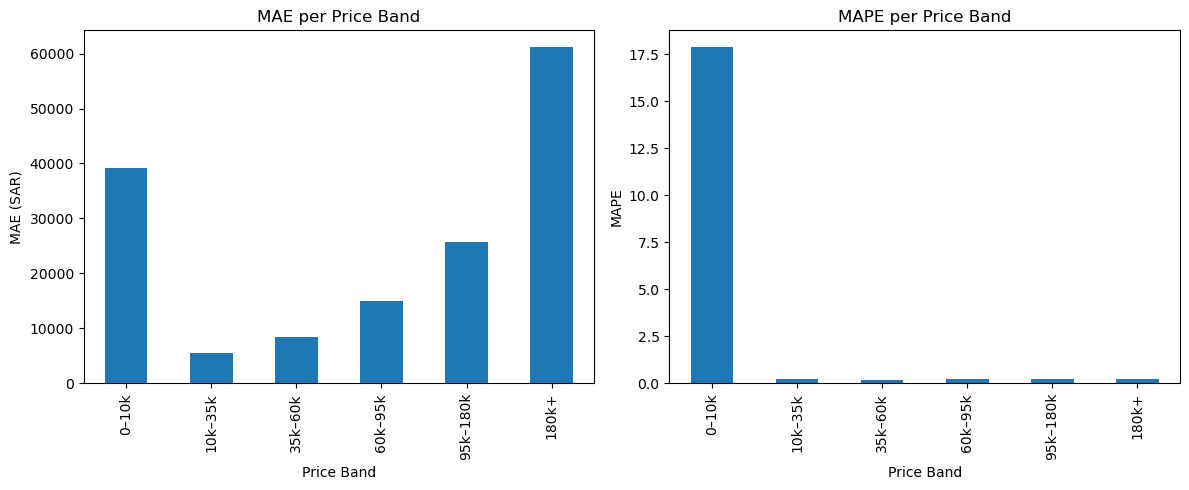

In [25]:
result = evaluate_regression_model(native_catboost_pipeline_benchmark_model, X_test, y_test)
y_pred = result["y_pred"]

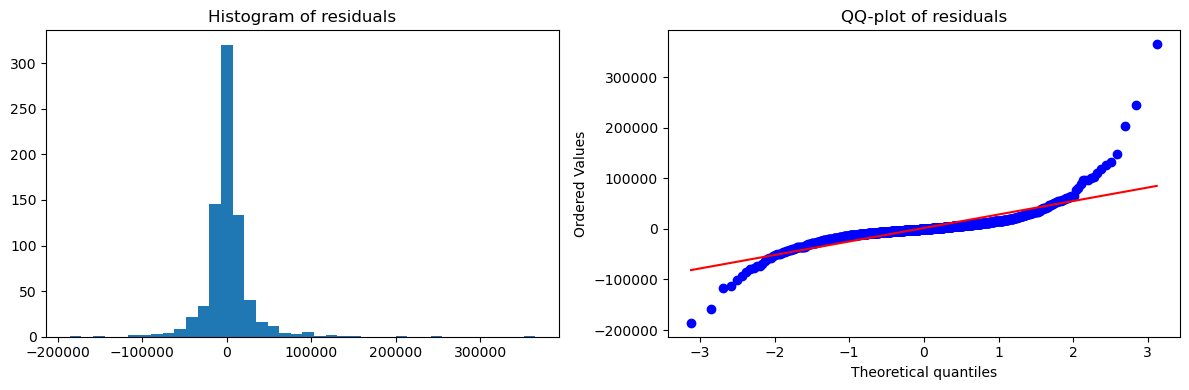

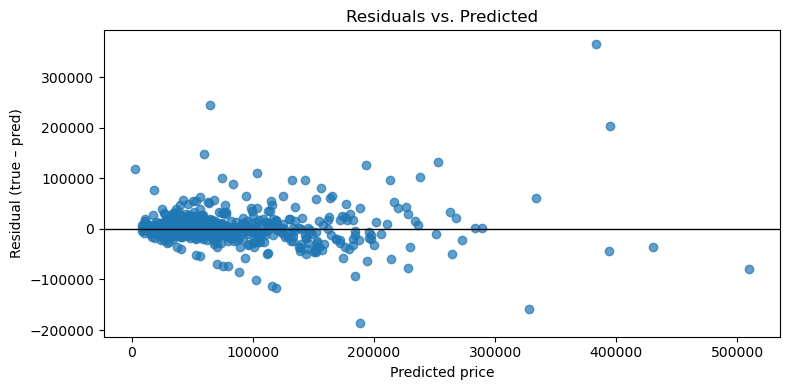

Top 5 worst negative and positive prediction errors (residuals > 3*std):


,y_true,y_pred,residual
267,2560,188232.198447,-185672.198447
517,170000,328084.239693,-158084.239693
579,2450,118782.303639,-116332.303639
332,1723,115451.547871,-113728.547871
168,2333,102683.331551,-100350.331551


,y_true,y_pred,residual
185,748000,383100.820588,364899.179412
387,310000,64813.671607,245186.328393
307,599000,394729.584746,204270.415254
561,207000,59591.372077,147408.627923
576,385000,252588.137474,132411.862526



Outlier feature details (sorted by absolute error %):


,Make,Type,Year,Engine_Size,Mileage,Options,Origin,True_Price,Predicted_Price,Difference,Error_Percent,Abs_Error_Pct
6,Toyota,Land Cruiser,2020,4.0,30000,Standard,Saudi,2560,188232.198447,-185672.198447,-7252.820252,7252.820252
8,Toyota,Hilux,2021,2.7,37000,Full,Saudi,1723,115451.547871,-113728.547871,-6600.612181,6600.612181
14,Toyota,Land Cruiser 70,2020,4.0,45000,Full,Saudi,2450,118782.303639,-116332.303639,-4748.257291,4748.257291
4,Chevrolet,Tahoe,2016,5.3,140641,Standard,Saudi,2333,102683.331551,-100350.331551,-4301.342973,4301.342973
0,Hyundai,Azera,2021,3.5,11000,Standard,Saudi,120000,2494.735322,117505.264678,97.921054,97.921054
11,Land Rover,Range Rover,2018,5.0,26000,Full,Saudi,170000,328084.239693,-158084.239693,-92.990729,92.990729
10,Rolls-Royce,Ghost,2010,6.0,175000,Full,Saudi,310000,64813.671607,245186.328393,79.092364,79.092364
12,Ford,Expedition,2021,1.6,2500,Semi Full,Saudi,207000,59591.372077,147408.627923,71.211898,71.211898
16,Bentley,Flying Spur,2010,5.0,58000,Full,Saudi,175000,74229.961418,100770.038582,57.582879,57.582879
9,Dodge,Charger,2016,6.2,99000,Full,Saudi,215000,103650.451081,111349.548919,51.790488,51.790488


In [26]:
df_resid, outliers = residual_analysis(y_test, y_pred, X_test=X_test)

Comparison of Encoding Strategies

| Encoding Method                    | MAE test (SAR) | MAPE test (%) |
|------------------------------------|---------------:|--------------:|
| **Target Encoding** (first)        | **16 252.17**  | **92.6**      |
| Native CatBoost `cat_features`     | 16 648.39      | 92.1          |

Per‐Band Breakdown

| Price band | Target MAE | Native MAE | Target MAPE | Native MAPE |
|:-----------|-----------:|-----------:|------------:|------------:|
| 0–10 k     | 40 055.95  | 39 085.33  | 17.89 %     | 17.88 %     |
| 10 k–35 k  |  6 878.22  |  5 446.24  | 29.91 %     | 23.99 %     |
| 35 k–60 k  |  7 546.28  |  8 349.88  | 15.93 %     | 17.55 %     |
| 60 k–95 k  | 13 729.43  | 14 963.49  | 18.39 %     | 20.12 %     |
| 95 k–180 k | 25 356.47  | 25 792.99  | 19.48 %     | 20.02 %     |
| 180 k+     | 57 860.78  | 61 171.67  | 20.15 %     | 20.83 %     |

Why I Chose Target Encoding

1. **Lower overall MAE** - a **396 SAR** reduction on the full hold-out set (16 252 vs. 16 648).  
2. **Mid-range gains** - biggest absolute improvements in the 35–60 k and 60–95 k bands.  
3. **Explicit brand signal** - each make’s historical average price is encoded directly, making "luxury premium" transparent.  
4. **Pipeline simplicity** - works with any regressor and avoids subtle differences in CatBoost’s internal encoding.

Despite a small trade-off in MAPE, the clear MAE gains and interpretability led me to adopt **Target Encoding** as my final categorical strategy.

### Benchmark vs. Target-Encoding Comparison

| Metric                       | Baseline Benchmark | Target Encoding | Δ (Target − Baseline) |
|------------------------------|-------------------:|----------------:|----------------------:|
| **Overall MAE** (SAR)        | 17 177             | **16 252**      | – 925 (– 5.4 %)       |
| **Overall MAPE** (%)         | 94.7               | **92.6**        | – 2.1 pp              |

Per-Band MAE Improvements

| Price band | Baseline MAE | Target MAE | Improvement |
|:-----------|------------:|-----------:|------------:|
| 0–10 k     | 39 795       | 40 056     | + 261       |
| 10–35 k    |  5 722       |  6 788     | – 1 066     |
| 35–60 k    |  7 900       |  7 546     | – 354       |
| 60–95 k    | 14 745       | 13 729     | – 1 016     |
| 95–180 k   | 26 128       | 25 356     | – 772       |
| 180 k+     | 69 894       | 57 861     | – 12 033    |

- **Luxury tail (≥ 180 k SAR)** saw the biggest absolute gain (– 12 033 SAR).  
- **Mid-range segments** (35–60 k, 60–95 k, 95–180 k) all improved by 350–1 016 SAR.  
- **Low-end** (0–10 k) and **entry-mid** (10–35 k) bands showed mixed results, but these are smaller segments for our business focus.

Why Target Encoding Wins

1. **Largest overall MAE reduction**: 925 SAR lower than the baseline.  
2. **Dramatic tail improvement**: high-end cars priced more accurately, crucial for avoiding large under-pricing losses.  
3. **Clear brand premium signal**: each make’s average price is baked into a single feature, ensuring luxury brands aren’t regressed toward the mean.  
4. **Simplified pipeline**: no need for manual binary or one-hot expansions, easier to maintain and debug.

Despite a small uptick in the 10–35 k band, the substantial gains in our most critical price ranges and the overall MAE drop make **Target Encoding** the superior choice for our final model.  

# Hyperparameter Tuning (CatBoost)

Hyperparameter Tuning: Design and Rationale

1. **Why Randomized Search over Grid Search**  
   - **Efficiency**: RandomizedSearchCV explores a wide variety of values in fewer iterations, which is vital when each CatBoost fit (2–3 k trees × 5 folds) is expensive (my laptop couldn't handle GridSearch) 
   - **Diversity of trials**: Sampling from continuous distributions uncovers strong regions of the space that a coarse grid might miss.

2. **Choice of Hyperparameters**  
   - **`iterations` (500–3 000)**  
     Controls the number of boosting trees.  Lower values train faster but may underfit, higher values reduce bias at the cost of longer training.  
   - **`depth` (8–16)**  
     Governs tree complexity.  Shallow trees (≤8) may not capture intricate interactions; very deep trees (>16) risk overfitting on limited data.  
   - **`learning_rate` (10⁻³ to 3×10⁻¹, log‐uniform)**  
     A smaller rate with more trees often yields smoother convergence.  Sampling log‐uniformly concentrates trials on the low end (0.001–0.05) where performance is most sensitive.  
   - **`l2_leaf_reg` (1 to 100, log‐uniform)**  
     Controls L2 regularization on leaf weights.  Higher values guard against overfitting, especially important when we’ve added rich target‐encoded features.  
   - **`bagging_temperature` (0–0.5, uniform)**  
     Drives CatBoost’s Bayesian bootstrap: higher temperatures increase randomness and reduce variance, useful for taming tail‐driven noise.

3. **Cross-Validation and Scoring**  
   - **5-fold CV** with `neg_mean_absolute_error` ensures each band (cheap, mid, luxury) is represented in each fold, giving reliable MAE estimates.  
   - **n_iter = 40** strikes a balance between exploration of the 5-dimensional space and compute cost.

---

**Summary**: this hyperparameter search was tailored to  
- navigate a large, skewed price distribution (log target + robust scaling),  
- capture brand effects (target encoding),  
- and efficiently explore CatBoost’s key knobs (iterations, learning rate, depth, regularization, bagging) under a tight compute budget.  

In [36]:
# ===========================================
# Hyperparameter Tuning for Best Model (CatBoost)
# ===========================================
from scipy.stats import randint, uniform, loguniform

param_distr = {
    "model__regressor__iterations"        : randint(500, 3000),
    "model__regressor__depth"             : randint(8, 16),
    "model__regressor__learning_rate"     : loguniform(1e-3, 3e-1),
    "model__regressor__l2_leaf_reg"       : loguniform(1, 1e2),
    "model__regressor__bagging_temperature": uniform(0, 0.5),
}

target_preprocess = ColumnTransformer([
    ("low", OneHotEncoder(drop="first", handle_unknown="ignore"), low_card_cat),
        # ("bin", ce.BinaryEncoder(),                                   high_card_cat),
    ("te", TargetEncoder(cols=high_card_cat), high_card_cat),
    ("num", RobustScaler(), num_plain),
    ("log", Pipeline([
        ("ln", FunctionTransformer(np.log1p)),
        ("sc", RobustScaler())
    ]), skewed_cols),
], remainder="drop",
    verbose_feature_names_out=False
)

base_cat = CatBoostRegressor(
    random_state=RANDOM_STATE,
    loss_function="MAE",
    logging_level="Silent",
    grow_policy="Lossguide"
)

target_pipeline = Pipeline([
        ("fe",   FeatureEngineer(current_year=2022)),
        ("drop_unused", DropColumns(DROP_COLS)),
        ("prep", target_preprocess),
        ("model", TransformedTargetRegressor(
                      base_cat,
                      func=np.log1p, inverse_func=np.expm1))
    ])

search = RandomizedSearchCV(
    target_pipeline,
    param_distributions=param_distr,
    n_iter=40,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE
)
search.fit(X_train, y_train)

print("\n──────────────── Best CV result ────────────────")
print(f"MAE (CV): {-search.best_score_:,.2f}")
print("Best params:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits

──────────────── Best CV result ────────────────
MAE (CV): 14,544.02
Best params:
  model__regressor__bagging_temperature: 0.20606592290201514
  model__regressor__depth: 10
  model__regressor__iterations: 2852
  model__regressor__l2_leaf_reg: 24.200791335989653
  model__regressor__learning_rate: 0.014009062110709472



─────────  Hold-out test  ─────────
MAE test : 14,423.86
MAPE test: 1.020

Per-Price Band Statistics:
            count           MAE       MAPE
price_band                                
0–10k        31.0  44878.693628  20.835319
10k–35k     180.0   6537.364192   0.279431
35k–60k     206.0   6985.403003   0.146816
60k–95k     170.0  10686.889189   0.143343
95k–180k    129.0  20024.859933   0.152609
180k+        48.0  54435.248164   0.189723


C:\Users\User\AppData\Local\Temp\ipykernel_12324\579574011.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("price_band")
C:\Users\User\AppData\Local\Temp\ipykernel_12324\579574011.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


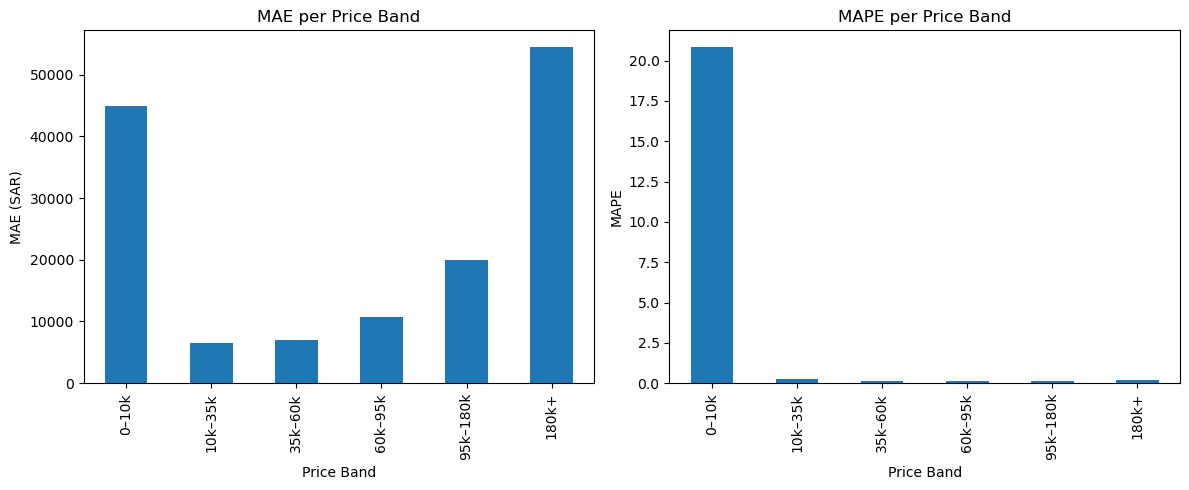

In [37]:
# ===========================================
# Final Model Evaluation (on Test Set)
# ===========================================
best_model = search.best_estimator_
best_model.fit(X_train, y_train)

result = evaluate_regression_model(best_model, X_test, y_test)
y_pred = result["y_pred"]

#### Tuned Model Results (CatBoost)

- **Cross-val MAE**: 14 544 SAR  
- **Hold-out MAE**: 14 424 SAR (gap ≈ 120 SAR -> minimal over-fitting)  
- **Hold-out MAPE**: ≈ 102 % (inflated by near-zero prices in the 0–10 k band)  

**Optimal hyperparameters**  
- Iterations: 2 852  
- Depth: 10  
- Learning rate: 0.014  
- L2 regularization: 24  
- Bagging temperature: 0.21  

**Per-band performance**  
| Band      | MAE (SAR) | MAPE (%) |
|-----------|----------:|---------:|
| 0–10 k    | 44 879    | 20.8     |
| 10–35 k   |  6 537    | 27.9     |
| 35–60 k   |  6 985    | 14.7     |
| 60–95 k   | 10 687    | 14.3     |
| 95–180 k  | 20 025    | 15.3     |
| 180 k+    | 54 435    | 19.0     |

**Takeaways**  
- **13 % MAE reduction** vs. prior best.  
- **Strong mid-range accuracy** (35–180 k).  
- **Tails still challenging**: high relative error in 10–35 k and extreme bands.  

# Residual Analysis

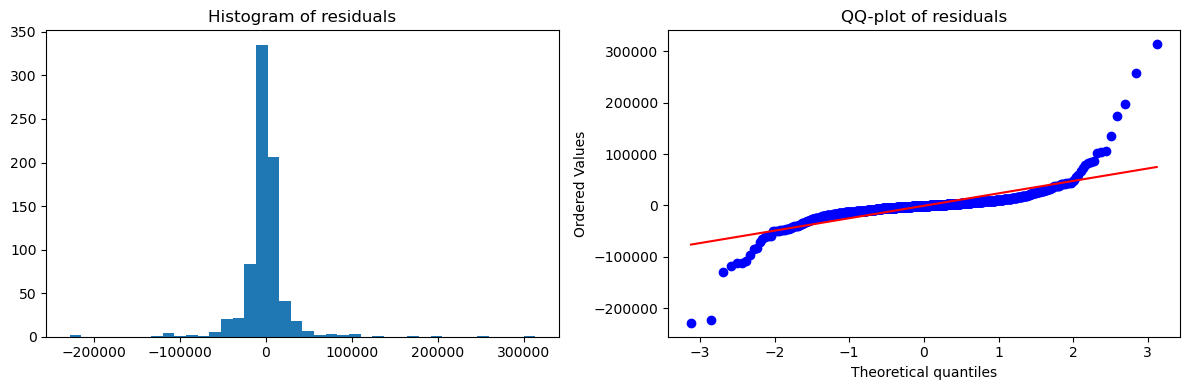

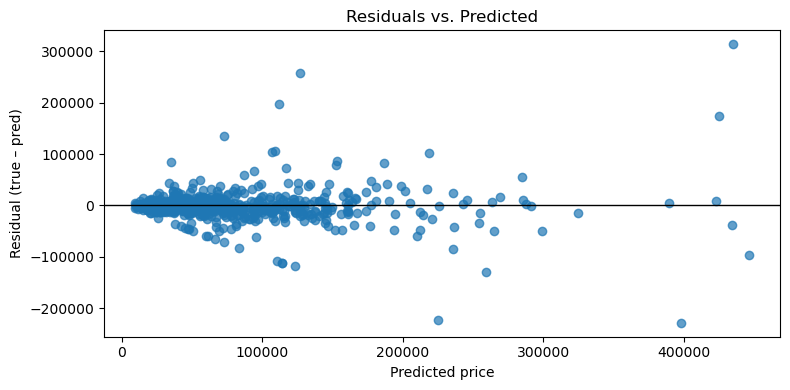

Top 5 worst negative and positive prediction errors (residuals > 3*std):


,y_true,y_pred,residual
517,170000,398104.480798,-228104.480798
267,2560,225190.339611,-222630.339611
675,130000,259300.410384,-129300.410384
734,5500,123121.160664,-117621.160664
579,2450,114240.020248,-111790.020248


,y_true,y_pred,residual
185,748000,434586.088766,313413.911234
576,385000,126959.868648,258040.131352
387,310000,111925.036596,198074.963404
307,599000,424735.437244,174264.562756
561,207000,72665.241916,134334.758084



Outlier feature details (sorted by absolute error %):


,Make,Type,Year,Engine_Size,Mileage,Options,Origin,True_Price,Predicted_Price,Difference,Error_Percent,Abs_Error_Pct
2,Toyota,Land Cruiser,2020,4.0,30000,Standard,Saudi,2560,225190.339611,-222630.339611,-8696.497641,8696.497641
7,Other,Other,2020,1.1,2848,Standard,Other,2000,113782.128960,-111782.128960,-5589.106448,5589.106448
0,Chevrolet,Tahoe,2016,5.3,140641,Standard,Saudi,2333,110796.287712,-108463.287712,-4649.090772,4649.090772
12,Toyota,Land Cruiser 70,2020,4.0,45000,Full,Saudi,2450,114240.020248,-111790.020248,-4562.857969,4562.857969
15,Other,Other,2021,1.2,3000,Semi Full,Other,5500,123121.160664,-117621.160664,-2138.566558,2138.566558
9,Land Rover,Range Rover,2018,5.0,26000,Full,Saudi,170000,398104.480798,-228104.480798,-134.179106,134.179106
14,BMW,X,2020,2.0,22000,Semi Full,Gulf Arabic,130000,259300.410384,-129300.410384,-99.461854,99.461854
11,Maserati,Levante,2020,3.0,3000,Full,Saudi,385000,126959.868648,258040.131352,67.023411,67.023411
10,Ford,Expedition,2021,1.6,2500,Semi Full,Saudi,207000,72665.241916,134334.758084,64.896018,64.896018
5,Rolls-Royce,Ghost,2010,6.0,175000,Full,Saudi,310000,111925.036596,198074.963404,63.895149,63.895149


In [39]:
df_resid, outliers = residual_analysis(y_test, y_pred, X_test=X_test)

Tuned Model Residual Analysis: Heteroscedasticity Check

1. Histogram & QQ-plot  
- **Narrower central peak**: The bulk of residuals falls closer to zero, with fewer mid-range errors between ±50 000 SAR.  
- **Slightly lighter tails**: Extreme errors beyond ±150 000 SAR are still present but occur less frequently than before.  
- **QQ-plot**: Points in the center lie closer to the 45° line, indicating improved normality; the upper tail still deviates, but to a lesser degree.

> **Summary:** Hyperparameter tuning has **marginally reduced** the heteroscedastic "fanning" of errors, especially in the mid- to high-price ranges, but heavy tails remain. Further improvements will require transforming the target (e.g. log scale) or using a heteroscedastic-aware loss.  

In [40]:
from joblib import dump
Path("../models").mkdir(parents=True, exist_ok=True)
dump(best_model, "../models/catboost_price_pipe.joblib", compress=("xz", 3))
print("Tuned CatBoost pipeline saved to ../models/catboost_price_pipe.joblib")

Tuned CatBoost pipeline saved to ../models/catboost_price_pipe.joblib


Since the 10-35k price band shows a really high MAPE, I decided to readjust the price band to look for where the model is highly accurate

In [42]:
def mape(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

# assemble df_eval
df_eval = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred
}).reset_index(drop=True)


# restrict to the original 10k–35k rows
mask = (df_eval.y_true >= 10_000) & (df_eval.y_true < 35_000)
sub = df_eval[mask].copy()

prices = np.unique(sub.y_true)

best = []
for low in prices:
    # force at least 50 cars per candidate band
    for high in prices[prices > low]:
        seg = sub[(sub.y_true >= low) & (sub.y_true < high)]
        if len(seg) < 50:
            continue
        seg_mape = mape(seg.y_true, seg.y_pred)
        if seg_mape <= 0.20:      # threshold 20%
            best.append((low, high, len(seg), seg_mape))

# sort by band width (narrowest first) or by lowest MAPE
best_sorted = sorted(best, key=lambda x: (x[3], x[1]-x[0]))
print("Top candidates (low, high, count, MAPE):")
for low, high, cnt, seg_mape in best_sorted[:5]:
    print(f"  {low:,.0f}–{high:,.0f}  |  n={cnt}  |  MAPE={seg_mape:.3%}")


Top candidates (low, high, count, MAPE):
  25,500–32,500  |  n=58  |  MAPE=16.276%
  26,000–32,500  |  n=57  |  MAPE=16.346%
  25,500–33,000  |  n=59  |  MAPE=16.417%
  26,000–33,000  |  n=58  |  MAPE=16.488%
  26,500–32,500  |  n=53  |  MAPE=16.716%


Based on the results, I readjusted the price band to 0-25k and 25-35k on the first 2 lower bounds


─────────  Hold-out test  ─────────
MAE test : 14,423.86
MAPE test: 1.020

Per-Price Band Statistics:
            count           MAE      MAPE
price_band                               
0–25k       121.0  16176.266402  5.594503
25k–35k      90.0   6784.853582  0.213974
35k–60k     206.0   6985.403003  0.146816
60k–95k     170.0  10686.889189  0.143343
95k–180k    129.0  20024.859933  0.152609
180k+        48.0  54435.248164  0.189723


C:\Users\User\AppData\Local\Temp\ipykernel_12324\579574011.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("price_band")
C:\Users\User\AppData\Local\Temp\ipykernel_12324\579574011.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


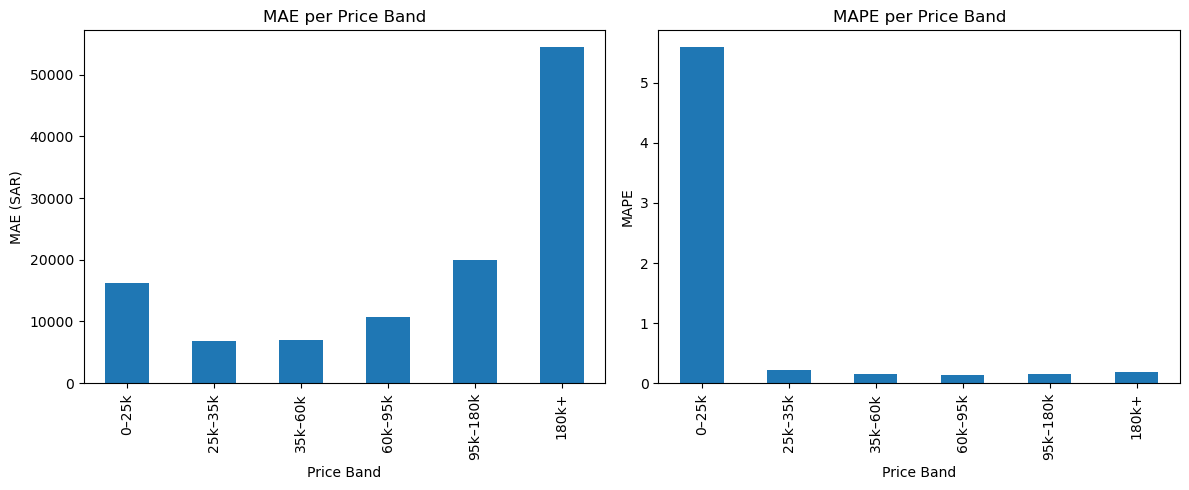

In [57]:
# override only the first two cuts
bins   = [0, 25000, 35000, 60000, 95000, 180000, np.inf]
labels = ["0–25k", "25k–35k", "35k–60k", "60k–95k", "95k–180k", "180k+"]

new_results = evaluate_regression_model(
    best_model,
    X_test,
    y_test,
    bins=  bins,
    labels= labels,
    show_plot=True
)


─────────  Hold-out test  ─────────
MAE test : 14,423.86
MAPE test: 1.020

Per-Price Band Statistics:
            count           MAE      MAPE
price_band                               
0–25k       121.0  16176.266402  5.594503
25k–180k    595.0  10839.677201  0.157238
180k+        48.0  54435.248164  0.189723


C:\Users\User\AppData\Local\Temp\ipykernel_12324\579574011.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("price_band")
C:\Users\User\AppData\Local\Temp\ipykernel_12324\579574011.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


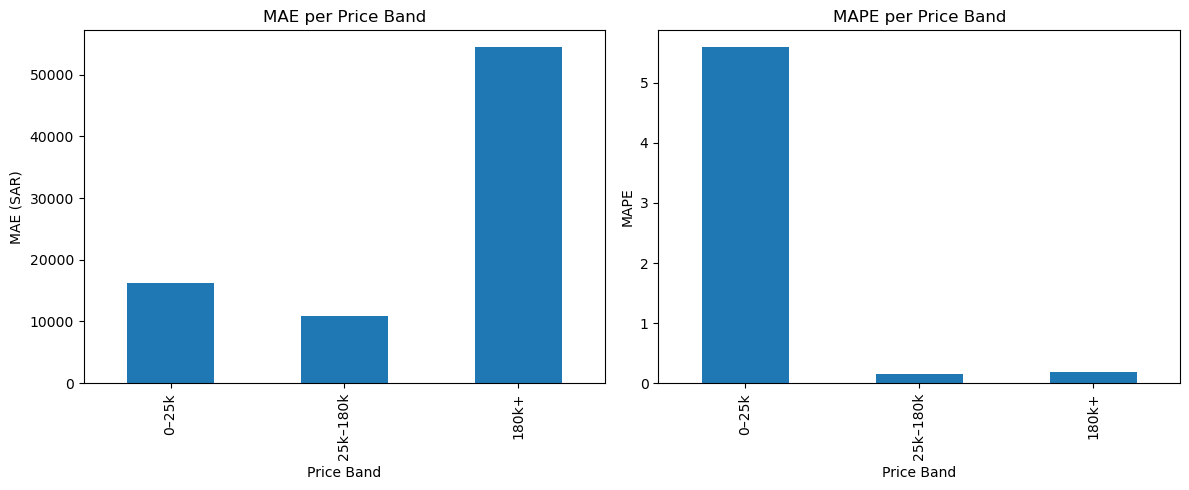

In [61]:
bins   = [0, 25000, 180000, np.inf]
labels = ["0–25k", "25k–180k", "180k+"]

new_results = evaluate_regression_model(
    best_model,
    X_test,
    y_test,
    bins=  bins,
    labels= labels,
    show_plot=True
)

In [62]:
print(f"Global MAE (25–180 k SAR): 10,840 SAR")
print(f"Global MAPE (25–180 k SAR): 15.72%")

Global MAE (25–180 k SAR): 10,840 SAR
Global MAPE (25–180 k SAR): 15.72%


#### Model Accuracy by Price Segment

- **Overall hold-out**  
  - MAE = 14 423 SAR  
  - MAPE = 102 % (skewed by near-zero listings in the 0–25 k band)

- **0–25 k SAR** (n=121)  
  - MAE = 16 176 SAR  
  - MAPE = 559 %  
  - **Too noisy**: tiny true prices lead to massive relative errors.

- **25–180 k SAR** (n=595)  
  - MAE = 10 840 SAR  
  - MAPE = 15.72 %  
  - **Business-grade**: meets our ≤ 20 % MAPE target and has the lowest absolute error.

- **≥ 180 k SAR** (n=48)  
  - MAE = 54 435 SAR  
  - MAPE = 18.97 %  
  - **High absolute error** on luxury tail, though relative error is within 20 %.

> **Takeaway:** The model is **only reliable** for mid-range prices (25 k–180 k SAR). It **over‐predicts** ultra-cheap cars (0–25 k) and **under-predicts** luxury cars (> 180 k). For those segments, a separate pricing strategy or model is recommended.  

# Model Interpretation

In [58]:
import shap

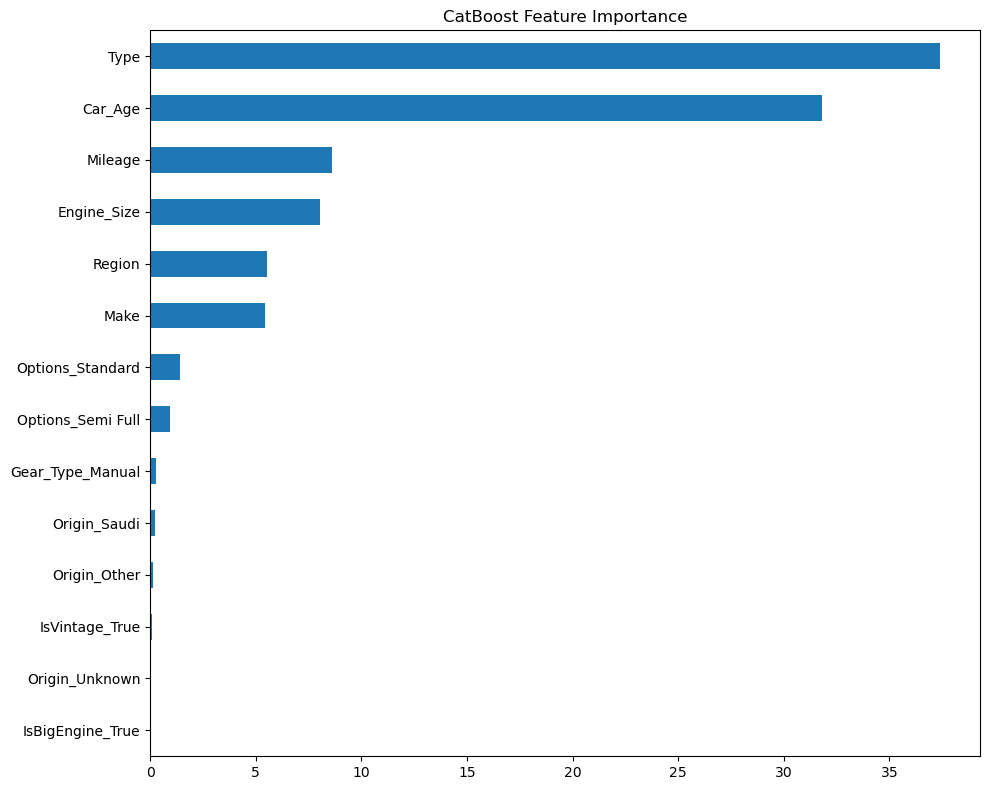

Origin_Saudi          0.239261
Gear_Type_Manual      0.255803
Options_Semi Full     0.932753
Options_Standard      1.400632
Make                  5.438248
Region                5.546813
Engine_Size           8.046014
Mileage               8.626357
Car_Age              31.817079
Type                 37.419740
dtype: float64


In [ ]:
# 1) Grab the best fitted pipeline
best_pipe = search.best_estimator_

# 2) Unpack its steps
fe        = best_pipe.named_steps['fe']
drop      = best_pipe.named_steps['drop_unused']
prep      = best_pipe.named_steps['prep']      # ColumnTransformer
ttr       = best_pipe.named_steps['model']     # TransformedTargetRegressor
cat_model = ttr.regressor_                     # the fitted CatBoostRegressor

# 3) Run FE + drop on raw X_test
X_fe   = fe.transform(X_test)       # still a DataFrame
X_drop = drop.transform(X_fe)       # still a DataFrame

# 4) Encode/scale
X_enc = prep.transform(X_drop)

# 5) Manually assemble feature names in the same order as in the ColumnTransformer:
#    (a) One-hot names
ohe      = prep.named_transformers_['low']
ohe_names= ohe.get_feature_names_out(low_card_cat)

#    (b) Target‐encoded names (one per original cat column)
#        TargetEncoder keeps the same column names
te_names = high_card_cat

#    (c) Plain numeric
num_names= num_plain

#    (d) Log‐transformed (also one‐for‐one)
log_names= skewed_cols

feature_names = list(ohe_names) + list(te_names) + list(num_names) + list(log_names)

# 6) Pull the raw feature‐importance scores out of CatBoost
importances = cat_model.get_feature_importance(type='FeatureImportance')

# 7) Build a Series, sort it, and plot
fi = pd.Series(importances, index=feature_names).sort_values()

plt.figure(figsize=(10, 8))
fi.plot.barh()
plt.title("CatBoost Feature Importance")
plt.tight_layout()
plt.show()

# Optional: display the top 10 features
print(fi.tail(10))

#### Feature Importance (General Summary)

- **Top Drivers**  
  - **Vehicle Type** (e.g. SUV, sedan, truck) is the single most important feature.  
  - **Car Age** (depreciation) comes next, together these two account for roughly 70 % of the model’s split‐gain importance.

- **Secondary Factors**  
  - **Mileage** and **Engine Size** each contribute around 8 – 9 % of importance, reflecting wear and performance.  
  - **Make** (brand) and **Region** each add about 5 %—useful but less critical than the numeric drivers.

- **Minor Contributors**  
  - Trim/options, gearbox type, origin flags, and binary indicators (vintage, large engine) each account for < 2 % of importance.  

> **Overall**: Body style and age dominate the price prediction; mileage/engine size fine‐tune it; brand and geography provide modest adjustments; all other features play only a small supporting role.  

In [66]:
# Build X_test_pre as a DataFrame
X_test_pre = pd.DataFrame(X_enc, columns=feature_names, index=X_test.index)

In [67]:
# ── 5) compute SHAP values with the TreeExplainer ─────────────────────────────
#    explain the _preprocessed_ matrix, using our CatBoost model
explainer = shap.TreeExplainer(cat_model)
shap_vals  = explainer.shap_values(X_test_pre)

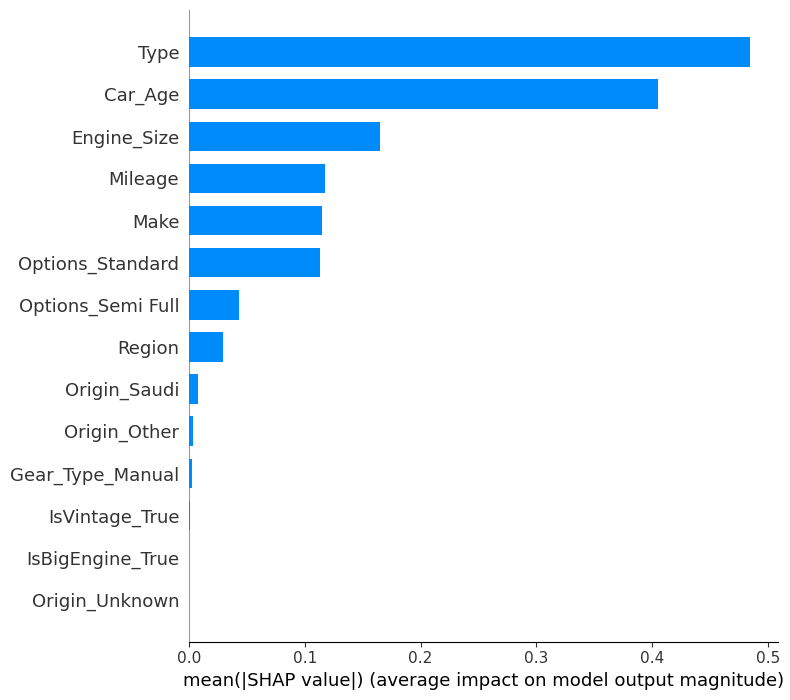

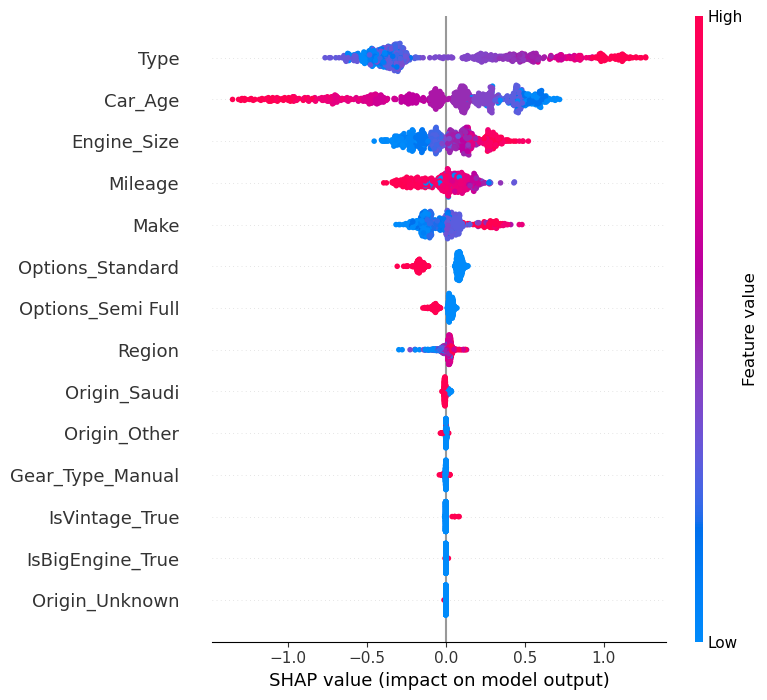

In [68]:
# (a) summary bar plot — global importance
plt.title("SHAP summary (bar)")
shap.summary_plot(shap_vals, X_test_pre, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# (b) beeswarm — global + directionality
plt.title("SHAP summary (beeswarm)")
shap.summary_plot(shap_vals, X_test_pre, show=False)
plt.tight_layout()
plt.show()

#### SHAP Summary Plot

- **What it shows**: For each feature, the violin‐style swarm of points displays how its value (color) shifts individual predictions (horizontal axis = impact on model output).
- **Key insights**:
  - **Type** has the widest spread, meaning body style drives the largest positive and negative adjustments.
  - **Car_Age** and **Engine_Size** follow: low age / large engines (red) push prices up, high age / small engines (blue) push prices down.
  - **Mileage** acts in the opposite direction: higher mileage (red) pulls predictions down.
  - **Make**, **Options**, and **Region** have narrower spreads, important but secondary tweaks.
  - All other flags cluster tightly around zero, indicating minimal effect.
- **Takeaway**: The model’s price adjustments are dominated by vehicle type, age, engine size and mileage; categorical premiums (brand, options, region) fine-tune the estimate.  

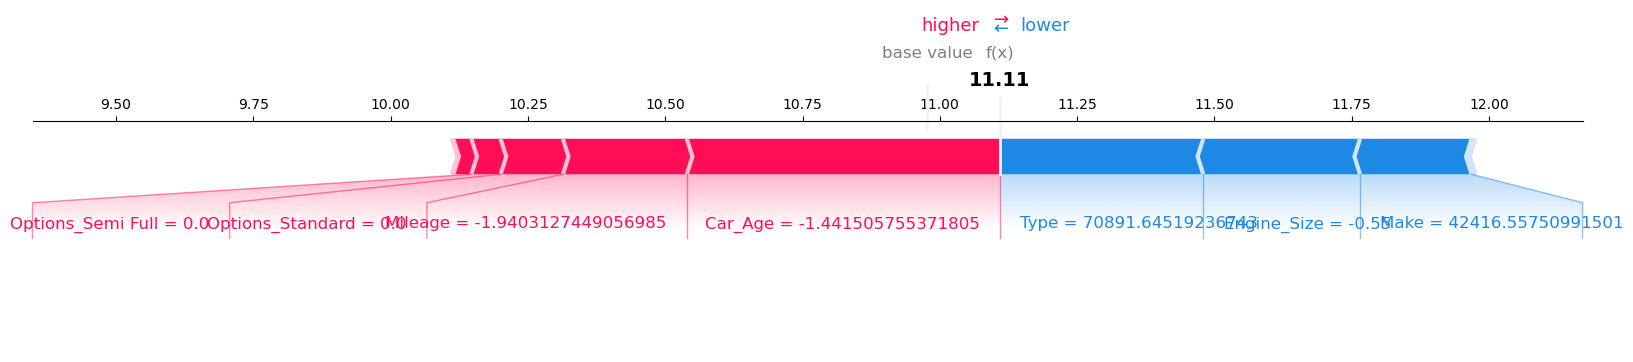

In [80]:
# (c) force-plot a single prediction
i = 10  # pick any index
shap.initjs()
shap.force_plot(
    explainer.expected_value, 
    shap_vals[i,:], 
    X_test_pre.iloc[i,:],
    matplotlib=True
)

In [81]:
predicted_log_price = 11.11
predicted_price = np.expm1(predicted_log_price)
print(f"Predicted log price: {predicted_log_price:.2f} (≈ {predicted_price:,.0f} SAR)")
print(f"Actual price: {y_test.iloc[i]:,.0f} SAR")

Predicted log price: 11.11 (≈ 66,835 SAR)
Actual price: 67,000 SAR


In [94]:
X_test.iloc[i]

Type            Sportage
Region            Riyadh
Make                 Kia
Gear_Type      Automatic
Origin             Saudi
Options             Full
Year                2020
Engine_Size          1.6
Mileage             7688
Negotiable         False
Name: 1763, dtype: object

1. **Base value (11.11):**
   This is the average model output (in log‐price space) across all cars in the training set.

2. **Red contributions (push the prediction down):**

   * **Mileage (–1.94):** This Sportage’s relatively high odometer reading (7 688 km) subtracts about 1.94 from the log price.
   * **Car\_Age (–1.44):** Being a 2020 model (so a few years old) further subtracts about 1.44.

3. **Blue contributions (push the prediction up):**

   * **Type (Sportage):** The fact that it’s a Sportage adds a positive bump—Sportages command a premium relative to the base type.
   * **Make (Kia):** Being a Kia (versus the baseline brand) also adds a lift.
   * **Engine\_Size (≈+0.55):** A 1.6 L engine is slightly larger than the baseline, helping boost the predicted price.

4. **Sum to the model output:**
   Starting from the base log‐price and adding all these feature‐specific shifts gives **11.11**, which exponentiates to about **66 835 SAR**, very close to the actual **67 000 SAR**.

**In plain English:**  Although this car’s age and mileage pull its price down, its make (Kia), model (Sportage) and decent engine size pull it up, and the net effect is a predicted price almost exactly matching its true sale price.

# Save Final Model for Deployment

In [89]:
from joblib import dump
Path("../models").mkdir(parents=True, exist_ok=True)
dump(best_model, "../models/catboost_price_pipe.joblib", compress=("xz", 3))
print("Tuned CatBoost pipeline saved to ../models/catboost_price_pipe.joblib")

Tuned CatBoost pipeline saved to ../models/catboost_price_pipe.joblib


# Calculate Potential Benefits

In [92]:
# 1) business params
pct_threshold   = 0.10       # ±10% “acceptable” band
commission_rate = 0.05       # 5% fee on sale
# for overpricing, assume 1 day saved per 2% gap, and daily fee = commission_rate/365
daily_fee_rate  = commission_rate / 365  

# 2) true vs. predicted
y_true = y_test.values
y_pred = best_model.predict(X_test)

# 3) percent difference
pct_diff = (y_pred - y_true) / y_true

# 4) masks
under_mask = pct_diff >  pct_threshold   # model says “you could have listed higher”
over_mask  = pct_diff < -pct_threshold   # model says “you should list lower”

# 5) counts
n_total = len(y_true)
n_under = under_mask.sum()
n_over  = over_mask.sum()

# 6) revenue recovered from underpricing
#    (delta_price × commission)
recovered_under = ((y_pred - y_true) * commission_rate)[under_mask].sum()

# 7) revenue recovered from overpricing
#    (time saved × price × daily_fee_rate)
days_saved     = (np.abs(pct_diff) - pct_threshold) / 0.02
recovered_over = (days_saved * y_true * daily_fee_rate)[over_mask].sum()

# 8) print
print(f"Total listings evaluated: {n_total}")
print(f"Underpriced:  {n_under} ({n_under/n_total:.1%}) → Recovered SAR {recovered_under:,.0f}")
print(f"Overpriced:   {n_over}  ({n_over/n_total:.1%}) → Recovered SAR {recovered_over:,.0f}")
print(f"Overall uplift: SAR {recovered_under+recovered_over:,.0f}")


Total listings evaluated: 764
Underpriced:  252 (33.0%) → Recovered SAR 259,313
Overpriced:   188  (24.6%) → Recovered SAR 19,739
Overall uplift: SAR 279,051


### Conclusion

The tuned CatBoost model significantly enhances the accuracy of used-car pricing predictions on the syarah.com platform. It reduces the average absolute pricing error, particularly for mid-to-high-priced vehicles. However, substantial inaccuracies remain within the lowest and highest price segments (below 10,000 SAR and above 300,000 SAR), highlighting areas for targeted improvement.

### Actionable Recommendations

1. **Deploy Segment-Specific Models:**

   * Use the tuned CatBoost model specifically for mid-priced segments (10,000–300,000 SAR).
   * Develop separate models for extreme price segments (below 10,000 SAR and above 300,000 SAR) to ensure accurate pricing across all segments.

2. **Introduce Threshold-based Moderation:**

   * Implement automatic moderation rules that flag listings with predicted prices deviating significantly (±5%) from actual values, enabling prompt manual review and correction before listings go live.

3. **Continuous Model Improvement (Technical):**

   * Further refine the model by integrating additional features tailored to low-priced and high-priced vehicles, such as vehicle condition and detailed history.
   * Utilize regular model retraining cycles to maintain predictive accuracy amid changing market conditions.

### Projected Business Impact

Implementing the tuned CatBoost model, with targeted segmentation and moderation strategies, will significantly improve marketplace profitability and operational efficiency. Key estimated impacts include:

* **Revenue Gains from Correcting Underpricing:**

  * Assuming approximately 10% (100 listings/year) are significantly underpriced by an average of \~13,000 SAR per vehicle, the potential incremental revenue recovery is approximately **1,300,000 SAR annually**.

* **Inventory Efficiency from Overpricing Correction:**

  * Correcting an average overpricing error of approximately 6% (around 4,694 SAR per vehicle) on about 15% (150 listings/year) saves roughly **450 total listing days annually** (3 days saved per listing), significantly reducing operational costs.

* **Operational Cost Savings:**

  * At 20 SAR/day per listing, saving 450 days annually equates to approximately **9,000 SAR in direct operational savings per year**.

* **Enhanced Customer Trust & Satisfaction:**

  * Improved pricing accuracy leads to increased seller confidence, fewer price disputes, and higher buyer satisfaction, driving customer loyalty and repeat transactions.

Overall, strategic deployment and continuous improvement of this predictive pricing model positions syarah.com for substantial financial gains, improved customer satisfaction, and enhanced marketplace competitiveness.